In [1]:
import os
import json
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [7]:
# Load mean and std values from the JSON file
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)
mean = np.array(mean_std['mean'])
std = np.array(mean_std['std'])

# Define the VGG16 model with frozen pretrained weights
def get_vgg16_model(num_classes):
    base_model = VGG16(weights='imagenet', include_top=False)
    
    # Unfreeze the top layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [8]:
# Define a transform that includes normalization with the previously computed mean and std
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.mean = mean
train_datagen.std = std

val_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
val_datagen.mean = mean
val_datagen.std = std

# Training and Evaluation Functions
def train_model(model, train_generator, val_generator, num_epochs=20, patience=3):
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

def evaluate_model(model, generator):
    results = model.evaluate(generator)
    return results

In [9]:
# Create directories for storing the k-fold datasets
base_dir = 'dataset_kfold'

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')

    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(244, 244),  # Image size specified here
        batch_size=8,  
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(244, 244),  # Image size specified here
        batch_size=8,  
        class_mode='categorical'
    )

    # Get the model and compile it
    num_classes = len(train_generator.class_indices)
    model = get_vgg16_model(num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(
        model, train_generator, val_generator, num_epochs=20, patience=3)

    # Save the model for this fold
    model_path = f'vgg16new_fold_{fold}.h5'
    model.save(model_path)
    print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')
    print(f'Training and evaluation for fold {fold} completed.\n')

# Print final accuracy and variance for all folds
average_accuracy = np.mean(fold_accuracies)
variance_accuracy = np.var(fold_accuracies)

print(f'Average accuracy across all folds: {average_accuracy * 100:.4f}')
print(f'Variance of accuracies across all folds: {variance_accuracy:.4f}')

Starting training for fold 0...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 717ms/step - accuracy: 0.3126 - loss: 1.8805 - val_accuracy: 0.6458 - val_loss: 1.1127 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 675ms/step - accuracy: 0.5318 - loss: 1.3266 - val_accuracy: 0.7396 - val_loss: 0.8406 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 676ms/step - accuracy: 0.6522 - loss: 1.0715 - val_accuracy: 0.8021 - val_loss: 0.7546 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 680ms/step - accuracy: 0.7162 - loss: 0.9361 - val_accuracy: 0.8021 - val_loss: 0.6686 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 685ms/step - accuracy: 0.7228 - loss: 0.9068 - val_accuracy: 0.8125 - val_loss: 0.6342 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 719ms/step - accuracy: 0.7912 - loss: 0.7730 - val_accuracy: 0.8750 - val_loss: 

Model for fold 0 saved at vgg16new_fold_0.h5
Evaluating model for fold 0...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.9497 - loss: 0.4068
Val loss: 0.4340, Val accuracy: 91.6667
Training and evaluation for fold 0 completed.

Starting training for fold 1...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 649ms/step - accuracy: 0.3534 - loss: 1.6856 - val_accuracy: 0.7500 - val_loss: 1.1750 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 655ms/step - accuracy: 0.6217 - loss: 1.2159 - val_accuracy: 0.7396 - val_loss: 1.0032 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 651ms/step - accuracy: 0.6845 - loss: 0.9808 - val_accuracy: 0.7292 - val_loss: 0.8986 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 708ms/step - accuracy: 0.7358 - loss: 0.8771 - val_accuracy: 0.8021 - val_loss: 0.8201 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━

Model for fold 1 saved at vgg16new_fold_1.h5
Evaluating model for fold 1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 531ms/step - accuracy: 0.8363 - loss: 0.6222
Val loss: 0.6905, Val accuracy: 81.2500
Training and evaluation for fold 1 completed.

Starting training for fold 2...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 668ms/step - accuracy: 0.3090 - loss: 1.7445 - val_accuracy: 0.6354 - val_loss: 1.2465 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 674ms/step - accuracy: 0.6120 - loss: 1.2096 - val_accuracy: 0.6042 - val_loss: 1.0951 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 674ms/step - accuracy: 0.6330 - loss: 1.0645 - val_accuracy: 0.6875 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.6919 - loss: 0.9193 - val_accuracy: 0.7708 - val_loss: 0.8683 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━

Model for fold 2 saved at vgg16new_fold_2.h5
Evaluating model for fold 2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step - accuracy: 0.7707 - loss: 0.7706
Val loss: 0.7491, Val accuracy: 80.2083
Training and evaluation for fold 2 completed.

Starting training for fold 3...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 635ms/step - accuracy: 0.3325 - loss: 1.7244 - val_accuracy: 0.6875 - val_loss: 1.1826 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - accuracy: 0.6156 - loss: 1.1997 - val_accuracy: 0.6146 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 650ms/step - accuracy: 0.7437 - loss: 0.9569 - val_accuracy: 0.7396 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 634ms/step - accuracy: 0.6741 - loss: 0.9489 - val_accuracy: 0.7396 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━

Model for fold 3 saved at vgg16new_fold_3.h5
Evaluating model for fold 3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.7645 - loss: 0.6833
Val loss: 0.7440, Val accuracy: 76.0417
Training and evaluation for fold 3 completed.

Starting training for fold 4...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.2986 - loss: 1.7364 - val_accuracy: 0.6667 - val_loss: 1.1712 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 665ms/step - accuracy: 0.5785 - loss: 1.2046 - val_accuracy: 0.7396 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 712ms/step - accuracy: 0.7522 - loss: 1.0100 - val_accuracy: 0.7604 - val_loss: 0.8529 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 703ms/step - accuracy: 0.6644 - loss: 1.0063 - val_accuracy: 0.7812 - val_loss: 0.7247 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━

Model for fold 4 saved at vgg16new_fold_4.h5
Evaluating model for fold 4...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - accuracy: 0.9073 - loss: 0.4815
Val loss: 0.4602, Val accuracy: 90.6250
Training and evaluation for fold 4 completed.

Average accuracy across all folds: 83.9583
Variance of accuracies across all folds: 0.0038


Loading model for fold 0...
Found 96 images belonging to 4 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step
Fold 0 - AUC-ROC for class glioma: 0.9969
Fold 0 - AUC-ROC for class meningioma: 0.9744
Fold 0 - AUC-ROC for class notumor: 0.9970
Fold 0 - AUC-ROC for class pituitary: 0.9802


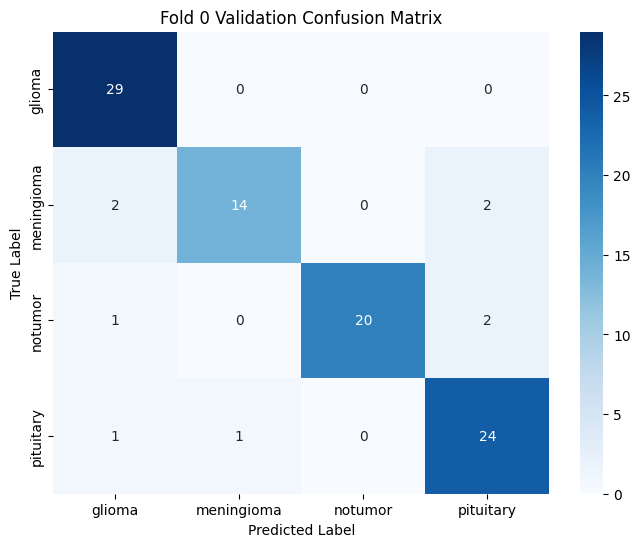

Classification Report for Fold 0:
              precision    recall  f1-score   support

      glioma       0.88      1.00      0.94        29
  meningioma       0.93      0.78      0.85        18
     notumor       1.00      0.87      0.93        23
   pituitary       0.86      0.92      0.89        26

    accuracy                           0.91        96
   macro avg       0.92      0.89      0.90        96
weighted avg       0.91      0.91      0.91        96

Class-wise TP, TN, FP, FN for Fold 0:
Class: glioma, TP: 29, TN: 63, FP: 4, FN: 0
Class: meningioma, TP: 14, TN: 77, FP: 1, FN: 4
Class: notumor, TP: 20, TN: 73, FP: 0, FN: 3
Class: pituitary, TP: 24, TN: 66, FP: 4, FN: 2
Loading model for fold 1...
Found 96 images belonging to 4 classes.


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step
Fold 1 - AUC-ROC for class glioma: 0.9646
Fold 1 - AUC-ROC for class meningioma: 0.9318
Fold 1 - AUC-ROC for class notumor: 0.9366
Fold 1 - AUC-ROC for class pituitary: 0.9593


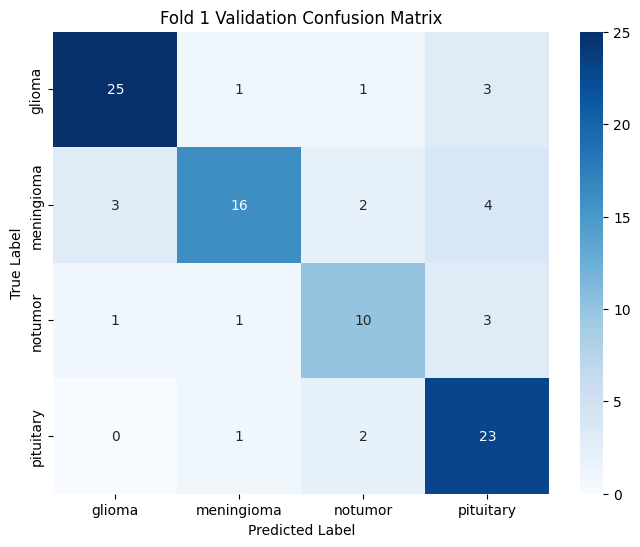

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.86      0.83      0.85        30
  meningioma       0.84      0.64      0.73        25
     notumor       0.67      0.67      0.67        15
   pituitary       0.70      0.88      0.78        26

    accuracy                           0.77        96
   macro avg       0.77      0.76      0.76        96
weighted avg       0.78      0.77      0.77        96

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 25, TN: 62, FP: 4, FN: 5
Class: meningioma, TP: 16, TN: 68, FP: 3, FN: 9
Class: notumor, TP: 10, TN: 76, FP: 5, FN: 5
Class: pituitary, TP: 23, TN: 60, FP: 10, FN: 3
Loading model for fold 2...


Found 96 images belonging to 4 classes.


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 464ms/step
Fold 2 - AUC-ROC for class glioma: 0.9336
Fold 2 - AUC-ROC for class meningioma: 0.8780
Fold 2 - AUC-ROC for class notumor: 0.9444
Fold 2 - AUC-ROC for class pituitary: 0.9219


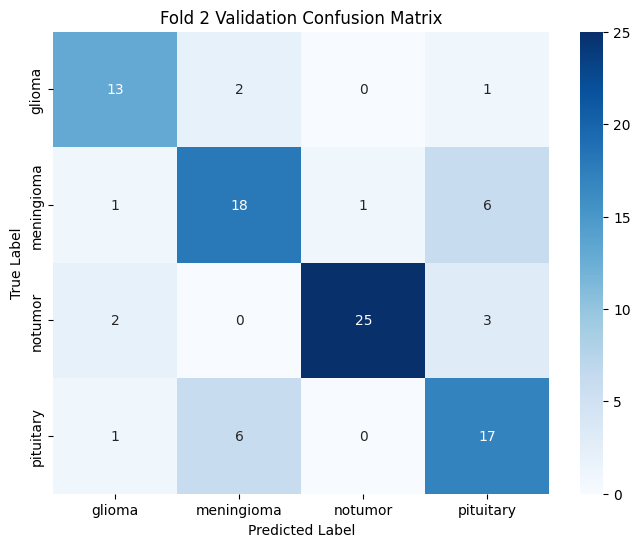

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.76      0.81      0.79        16
  meningioma       0.69      0.69      0.69        26
     notumor       0.96      0.83      0.89        30
   pituitary       0.63      0.71      0.67        24

    accuracy                           0.76        96
   macro avg       0.76      0.76      0.76        96
weighted avg       0.77      0.76      0.76        96

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 13, TN: 76, FP: 4, FN: 3
Class: meningioma, TP: 18, TN: 62, FP: 8, FN: 8
Class: notumor, TP: 25, TN: 65, FP: 1, FN: 5
Class: pituitary, TP: 17, TN: 62, FP: 10, FN: 7
Loading model for fold 3...


Found 96 images belonging to 4 classes.


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step
Fold 3 - AUC-ROC for class glioma: 0.9672
Fold 3 - AUC-ROC for class meningioma: 0.8776
Fold 3 - AUC-ROC for class notumor: 0.9404
Fold 3 - AUC-ROC for class pituitary: 0.9738


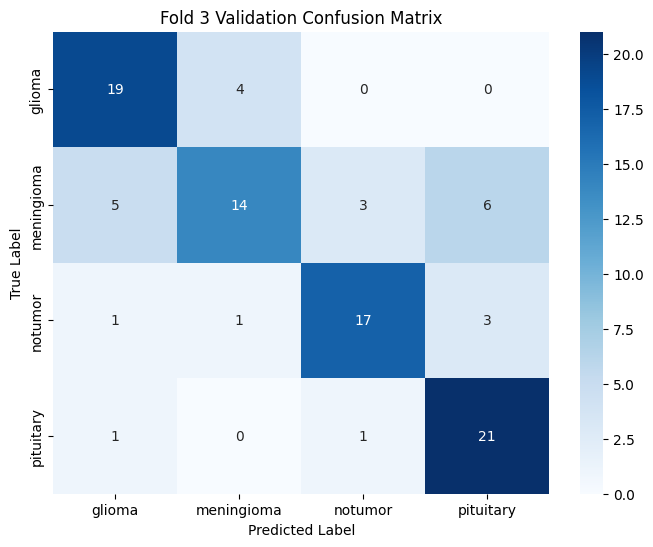

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.73      0.83      0.78        23
  meningioma       0.74      0.50      0.60        28
     notumor       0.81      0.77      0.79        22
   pituitary       0.70      0.91      0.79        23

    accuracy                           0.74        96
   macro avg       0.74      0.75      0.74        96
weighted avg       0.74      0.74      0.73        96

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 19, TN: 66, FP: 7, FN: 4
Class: meningioma, TP: 14, TN: 63, FP: 5, FN: 14
Class: notumor, TP: 17, TN: 70, FP: 4, FN: 5
Class: pituitary, TP: 21, TN: 64, FP: 9, FN: 2
Loading model for fold 4...


Found 96 images belonging to 4 classes.


c:\Users\Jacelyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 469ms/step
Fold 4 - AUC-ROC for class glioma: 0.9889
Fold 4 - AUC-ROC for class meningioma: 0.9512
Fold 4 - AUC-ROC for class notumor: 0.9833
Fold 4 - AUC-ROC for class pituitary: 0.9917


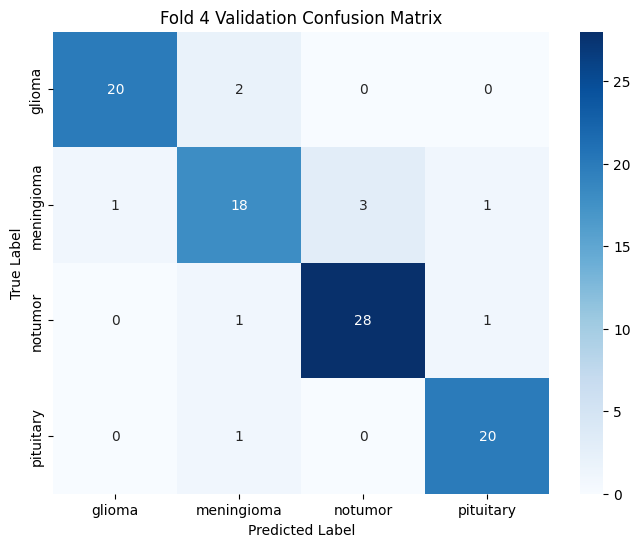

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93        22
  meningioma       0.82      0.78      0.80        23
     notumor       0.90      0.93      0.92        30
   pituitary       0.91      0.95      0.93        21

    accuracy                           0.90        96
   macro avg       0.90      0.89      0.89        96
weighted avg       0.90      0.90      0.90        96

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 20, TN: 73, FP: 1, FN: 2
Class: meningioma, TP: 18, TN: 69, FP: 4, FN: 5
Class: notumor, TP: 28, TN: 63, FP: 3, FN: 2
Class: pituitary, TP: 20, TN: 73, FP: 2, FN: 1


In [10]:
# Confusion Matrix, AUC-ROC, and Classification Report for each fold
for fold in range(5):
    print(f'Loading model for fold {fold}...')
    model_path = f'vgg16new_fold_{fold}.h5'
    model = tf.keras.models.load_model(model_path)

    # Load the validation dataset for the current fold
    val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224), 
        batch_size=8,
        class_mode='categorical',
        shuffle=False
    )

    # Make predictions on the validation data
    val_predictions = model.predict(val_generator)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = val_generator.classes

    # Compute the confusion matrix for this fold
    val_conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

    # Compute the AUC-ROC for each class
    val_true_classes_one_hot = tf.keras.utils.to_categorical(val_true_classes, num_classes)
    auc_roc_scores = {}
    for i, class_name in enumerate(val_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(val_true_classes_one_hot[:, i], val_predictions[:, i])
        roc_auc = auc(fpr, tpr)
        auc_roc_scores[class_name] = roc_auc
        print(f'Fold {fold} - AUC-ROC for class {class_name}: {roc_auc:.4f}')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold}:')
    print(classification_report(val_true_classes, val_predictions_classes, target_names=list(val_generator.class_indices.keys())))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = val_conf_matrix[i, i]
        fp = np.sum(val_conf_matrix[:, i]) - tp
        fn = np.sum(val_conf_matrix[i, :]) - tp
        tn = np.sum(val_conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")


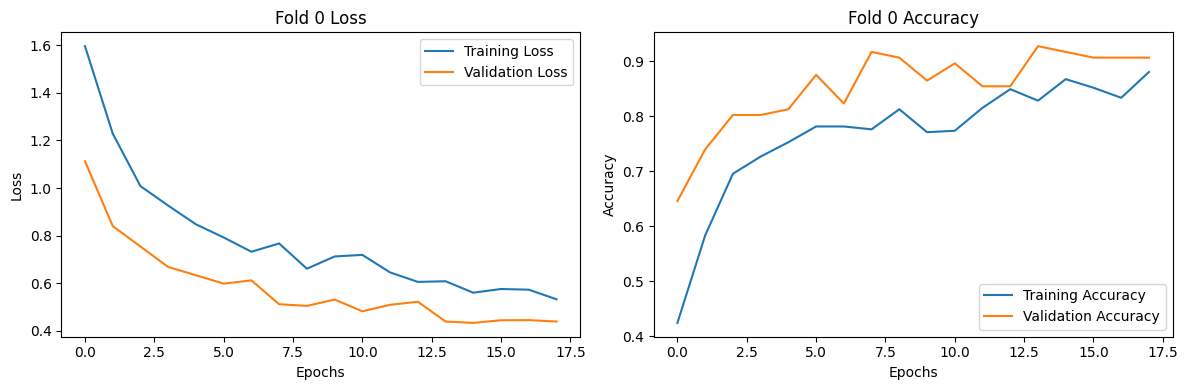

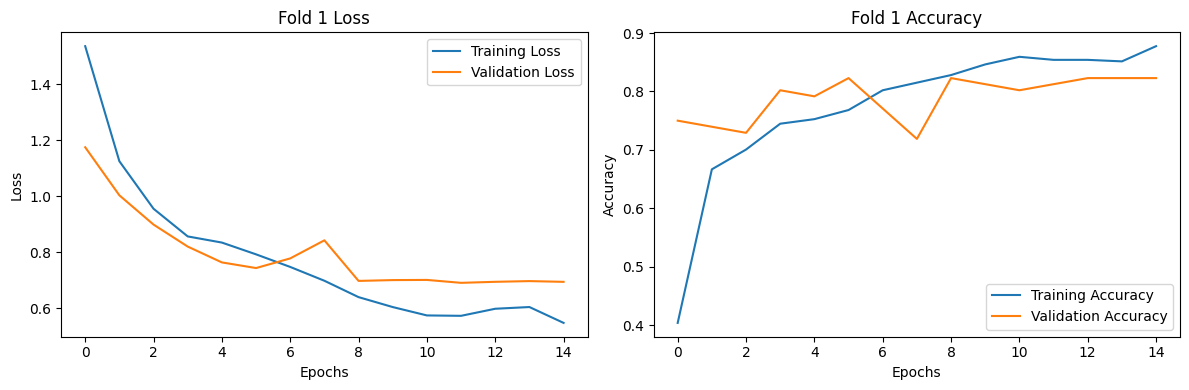

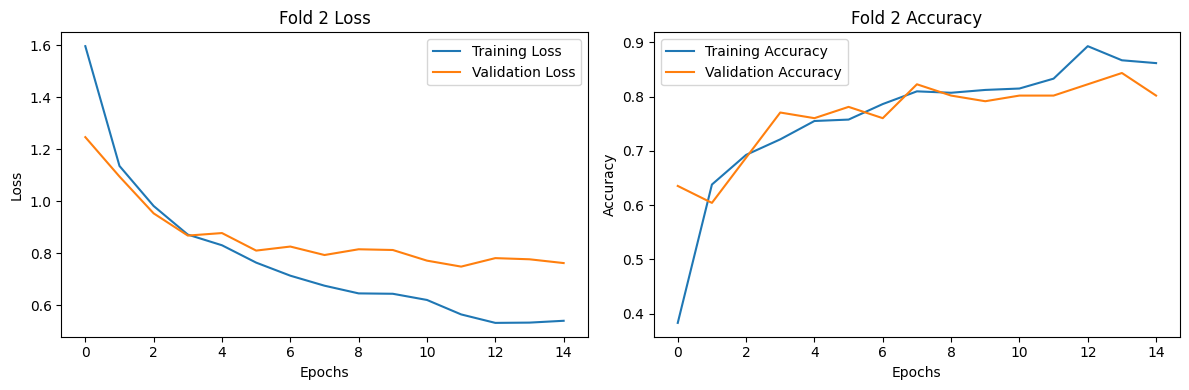

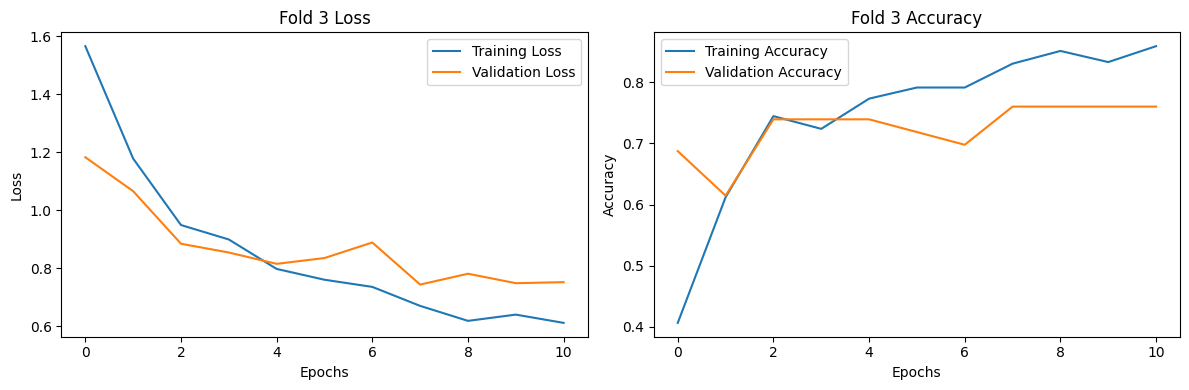

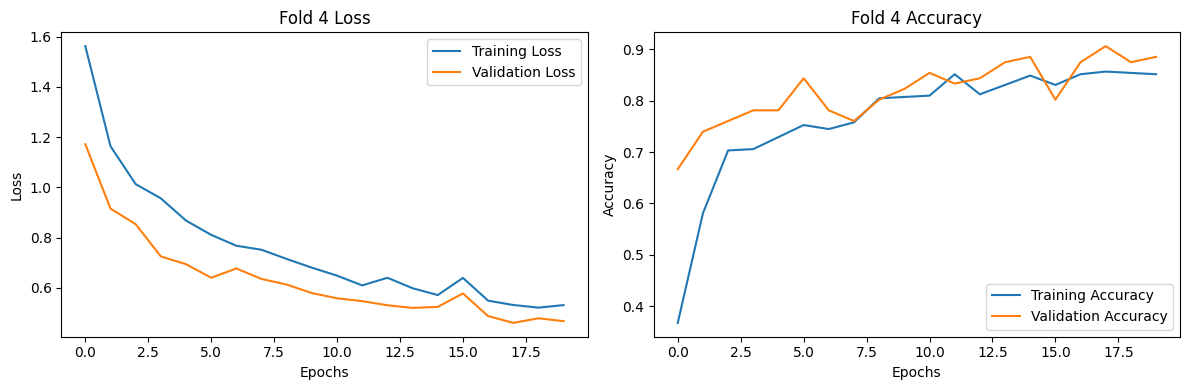

Accuracies for each fold:
Fold 0: 91.67%
Fold 1: 81.25%
Fold 2: 80.21%
Fold 3: 76.04%
Fold 4: 90.62%


In [11]:
# Plotting Results and Printing Fold Accuracies
def plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies):
    for fold in range(5):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[fold], label='Training Loss')
        plt.plot(all_val_losses[fold], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(all_train_accuracies[fold], label='Training Accuracy')
        plt.plot(all_val_accuracies[fold], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")

In [12]:
# Print final accuracy and variance for all folds
average_accuracy = np.mean(fold_accuracies)
variance_accuracy = np.var(fold_accuracies)

print(f'Average accuracy across all folds: {average_accuracy * 100:.4f}')
print(f'Variance of accuracies across all folds: {variance_accuracy* 100:.4f}')

Average accuracy across all folds: 83.9583
Variance of accuracies across all folds: 0.3759


In [13]:
# Define the function to predict a random image
def predict_random_image(base_dir, model_path, target_size=(224, 224)):
    # Load the model
    model = load_model(model_path)

    # Get a list of all class directories
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Choose a random class directory
    random_class = random.choice(class_dirs)
    random_class_dir = os.path.join(base_dir, random_class)

    # Get a list of all images in the chosen class directory
    image_files = [f for f in os.listdir(random_class_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    # Choose a random image file
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(random_class_dir, random_image_file)

    # Load and preprocess the image
    img = load_img(random_image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array -= mean
    img_array /= std

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Get the class labels
    class_labels = {v: k for k, v in val_generator.class_indices.items()}
    predicted_label = class_labels[predicted_class]

    # Display the image with predicted and true labels
    plt.imshow(img)
    plt.title(f"True: {random_class}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Base directory containing the dataset
base_dir = 'dataset_kfold/fold_0/val'

# Path to the saved model from fold 0
model_path = 'vgg16new_fold_0.h5'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


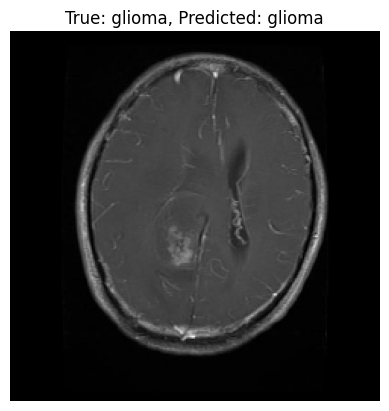

In [18]:
# Predict and display a random image
predict_random_image(base_dir, model_path, target_size=(244, 244))